# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [11]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def separate_lines(img, lines, color=[255, 0, 0], thickness=10):
#     print(lines)

#definition of global variables used for the moving average
    global slopes_right 
    global slopes_left
    global bias_right
    global bias_left
    
    imshape = img.shape  #get the shape of the video frame
    
#initialize global variables with safe values     
    bias_right_avg = 0
    bias_left_avg = 0
    slopes_right_avg = 1
    slopes_left_avg = 1
    
#initialize lists that will contain the separeted right and left lines  
    right_lines = []
    left_lines = []

    for line in lines: # separate the lines based on their slope
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            if m > 0:
                right_lines.append(line)
            else:
                left_lines.append(line)

    if len(right_lines) is not 0:   #process right lines, get the average slope and bias
        avg_right = (sum(right_lines) / len(right_lines))
        for x1,y1,x2,y2 in avg_right:
            slopeR = (y2 - y1) / (x2 - x1)  #get the average slope
            b = slopeR * (-x1) + y1  #get the average bias 
            slopes_right = np.insert(slopes_right,0,slopeR)  # save the slopes for the moving average
            slopes_right = slopes_right[-size_avg:]     # remember only the slops form the last size_avg frames   
            bias_right = np.insert(bias_right,0,b)  # save the biases for the moving average
            bias_right = bias_right[-size_avg:]  # remember only the biases form the last size_avg frames 



    bias_right_avg = bias_right.mean() # get the bias moving average
    slopes_right_avg = slopes_right.mean() # get the slope moving average
    y0 = imshape[0] - imshape[0]/2.5   #define initial y coordinate intersect 
    yf =imshape[0]   #define final y coordinate intersect 
    x0 = (y0 - bias_right_avg) / slopes_right_avg  # calculate x intersects 
    xf = (yf - bias_right_avg) / slopes_right_avg
    cv2.line(img, (int(x0), int(y0)), (int(xf), int(yf)), color, thickness) # draw the final averaged right line

 # same process repeated with left lines.        
    if len(left_lines) is not 0:
        avg_left = (sum(left_lines) / len(left_lines))
        for x1,y1,x2,y2 in avg_left:
            slopeL = (y2 - y1) / (x2 - x1)
            b = slopeL * (-x1) + y1  
            slopes_left = np.insert(slopes_left,0,slopeL)
            slopes_left = slopes_left[-size_avg:]
            bias_left = np.insert(bias_left,0,b)
            bias_left = bias_left[-size_avg:]
                   
    slopes_left_avg =slopes_left.mean()
    bias_left_avg =bias_left.mean()
    y0 = imshape[0] - imshape[0]/2.5
    yf =imshape[0]
    x0 = (y0 - bias_left_avg) / slopes_left_avg
    xf = (yf - bias_left_avg) / slopes_left_avg
    cv2.line(img, (int(x0), int(y0)), (int(xf), int(yf)), color, thickness)
    
#     return prevR_slope, prevL_slope

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #this helper function was modified to return 2 image arrays: one with the raw lines and one with the final separated (left, right), 
    #averarged and extrapolated lines
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    sep_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    separate_lines(sep_img, lines)
    return line_img, sep_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def to_white_n_filter(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([80, 100, 100]) 
    mask_inverse = cv2.inRange(hsv, lower_yellow, upper_yellow)    
    masked_replace_white = cv2.addWeighted(img, 1, \
                                       cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)
    red_threshold = 240
    green_threshold = 240
    blue_threshold = 240

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
        # Mask pixels below the threshold
    color_thresholds = (masked_replace_white[:, :, 0] < rgb_threshold[0]) | \
                       (masked_replace_white[:, :, 1] < rgb_threshold[1]) | \
                       (masked_replace_white[:, :, 2] < rgb_threshold[2])
            
        # Mask color and region selection
    masked_replace_white[color_thresholds] = [0, 0, 0]
    # Color pixels red where both color and region selections met
    masked_replace_white[~color_thresholds] = [255, 255, 255]
    
#     masked_edges = cv2.bitwise_and(edges, mask)
    
    return masked_replace_white

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
# code to get only the list of images in the test directory
import fnmatch
import os
dir_list= os.listdir('test_images/')
img_list = []
for file in dir_list :
    if fnmatch.fnmatch(file, '*.jpg'):
        img_list.append(file)
print(img_list)


['challenge_1.jpg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


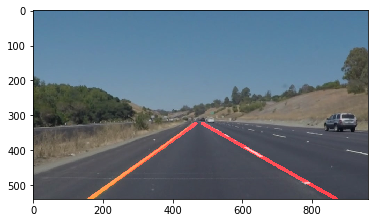

In [12]:
# Initialize the global variables for the moving average, in this case take into acount only the actual value so no averaging  
size_avg = 1  # size of the moving average filter

# Initialize the slopes arrays, delete any values as they might affect the averaging
slopes_right = np.ones(1)
slopes_right = np.delete(slopes_right,0)
slopes_left = np.ones(1)
slopes_left = np.delete(slopes_left,0)

bias_right = np.zeros(1)
bias_right = np.delete(bias_right, 0)
bias_left = np.zeros(1) 
bias_left = np.delete(bias_left, 0)

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')


import fnmatch
import os
# save only image files from the test_images folder
dir_list= os.listdir('test_images/')
img_list = []
for file in dir_list :
    if fnmatch.fnmatch(file, '*.jpg'):
        img_list.append(file)

#choose the desired image file to process
file = img_list[3]
    
image = mpimg.imread('test_images/' + file)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

white_img = to_white_n_filter(image)  #change any yellow pixel to white and filter the rest of the colors
    
gray_img = grayscale(white_img)  # convert to grayscale

smooth_img = gaussian_blur(gray_img, 5)  # apply gaussian smoothing

edges_img = canny(smooth_img, 40, 120)  # detect edges

imshape = image.shape

y_lim = 320  # set the y coordnate limit for the region of interest 
vertices = np.array([[(0,imshape[0]),(475, y_lim), (480, y_lim), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(edges_img, vertices)

# save the image in each step of the pipeline to have a better understanding of the proccess and troubleshooting
file_name = file.split('.')
mpimg.imsave('test_images_output/' + file_name[0] + '_yellow.' + file_name[1] , white_img, cmap='gray', format='jpg')
mpimg.imsave('test_images_output/' + file_name[0] + '_mask.' + file_name[1] , masked_image, cmap='gray', format='jpg')

line_img,sep_img  = hough_lines(masked_image, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
mpimg.imsave('test_images_output/' + file_name[0] + '_line.' + file_name[1], line_img, cmap='gray', format='jpg')
mpimg.imsave('test_images_output/' + file_name[0] + '_sep.' + file_name[1], sep_img, cmap='gray', format='jpg')

final_img = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
mpimg.imsave('test_images_output/' + file, final_img, cmap='gray', format='jpg')

avg_img = weighted_img(sep_img, image, α=0.8, β=1., λ=0.)
mpimg.imsave('test_images_output/' + file_name[0] + '_avg.' + file_name[1], avg_img, cmap='gray', format='jpg')
#     plt.figure()
plt.imshow(avg_img)  #show the resulting image

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# the main process_image function, this one returns the final result 
# it contains the 7 steps described in the writeup 
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    white_img = to_white_n_filter(image)  #change any yellow pixel to white and filter the rest of the colors
    gray_img = grayscale(white_img)  # convert to grayscale
    smooth_img = gaussian_blur(gray_img, 5) # apply gaussian smoothing
    edges_img = canny(smooth_img, 40, 120)  # detect edges
    imshape = image.shape
    y_lim = 322  # y coordinate limit for the region of interest 
    vertices = np.array([[(0,imshape[0]),(475, y_lim), (480, y_lim), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_img, vertices)
    
    #this helper function was modified to return 2 image arrays: one with the raw lines and one with the final separated (left, right), 
    #averarged and extrapolated lines
    line_img, sep_img  = hough_lines(masked_image, rho=3, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    #the desired returned result contains the averarged and extrapolated lines saved in sep_img
    result = weighted_img(sep_img, image, α=0.8, β=1., λ=0.)

    return result

#additional process function to generate a video with raw lines. 
def process_image_line(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_img = grayscale(image)
    
    smooth_img = gaussian_blur(gray_img, 5)
    edges_img = canny(smooth_img, 40, 120)
    imshape = image.shape
    y_lim = 322
    vertices = np.array([[(0,imshape[0]),(475, y_lim), (480, y_lim), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_img, vertices)
    
    line_img, sep_img  = hough_lines(masked_image, rho=3, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    result = weighted_img(line_img, image, α=0.8, β=1., λ=0.)

    return result


#additional process function to generate a video with the result of the canny edge detection, just for debugging. 
def process_image_gray(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_img = grayscale(image)
    
    smooth_img = gaussian_blur(gray_img, 5)
    result = canny(smooth_img, 40, 120)

    return result

Let's try the one with the solid white lane on the right first ...

In [14]:

# Initialize the global variables for the moving average, in this case take into acount the 20 last frames for averaging  
size_avg = 20  # size of the moving average filter

# Initialize the slopes and bias arrays, delete any values as they might affect the averaging
slopes_right = np.ones(1)
slopes_right = np.delete(slopes_right,0)
slopes_left = np.ones(1)
slopes_left = np.delete(slopes_left,0)

bias_right = np.zeros(1)
bias_right = np.delete(bias_right, 0)
bias_left = np.zeros(1) 
bias_left = np.delete(bias_left, 0)

white_output = 'test_videos_output/solidWhiteRight.mp4'
# white_output = 'test_videos_output/solidWhiteRight_line.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 9.18 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
# Initialize the global variables for the moving average, in this case take into acount the 20 last frames for averaging  
size_avg = 20  # size of the moving average filter

# Initialize the slopes and bias arrays, delete any values as they might affect the averaging
slopes_right = np.ones(1)
slopes_right = np.delete(slopes_right,0)
slopes_left = np.ones(1)
slopes_left = np.delete(slopes_left,0)

bias_right = np.zeros(1)
bias_right = np.delete(bias_right, 0)
bias_left = np.zeros(1) 
bias_left = np.delete(bias_left, 0)

yellow_output = 'test_videos_output/solidYellowLeft_line.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_line.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_line.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 25.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_line.mp4 

Wall time: 27.8 s


Now for the one with the solid yellow lane on the left. This one's more tricky!